# 6-Body Solar System IRKGL 

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Definition-of-the-N-body-problem">Definition of the N-body problem</a></li>
    <li><a href="#Integrations">Integrations</a></li>
    <li><a href="#Errors-in-energy">Errors in energy</a></li>
    <li><a href="#Errors-in-position">Errors in position</a></li>
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
using OrdinaryDiffEq
using JLD2, FileIO
using Parameters,NBInclude
#using IRKGaussLegendre
using LaTeXStrings
using BenchmarkTools
#using RecursiveArrayTools

In [2]:
PATH_DATA="./Data/"

PATH_SRC="../../src_simd/"
include(string(PATH_SRC,"IRKGL_SIMD.jl"))
using .IRKGL_SIMD   


PATH_SRC="../../src_seq/"
include(string(PATH_SRC,"IRKGL_SEQ.jl"))
using .IRKGL_SEQ  


PATH_SRC="../../src/"
include(string(PATH_SRC,"MyBenchmarksTools.jl"))

launch_method_tests (generic function with 1 method)

In [3]:
PATH_SRC2="../../src_seq2/"
include(string(PATH_SRC2,"IRKGL_SEQ.jl"))
#include(string(PATH_SRC2,"IRKGL_Seq_Solver.jl"))
#include(string(PATH_SRC2,"IRKGL_Step_Functions.jl"))

using .IRKGL_SEQ2

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




In [4]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"Initial6Body.jl"))
include(string(PATH_ODES,"Nbody.jl"))
include(string(PATH_ODES,"Nbody2nd.jl"))
include(string(PATH_ODES,"NbodyDyn.jl"));

### Initial value problem: 6-body problem (outer solar system)

We consider $N=6$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [5]:
nruns=1

u0, Gm, bodylist = Initial6Body(Float64)
u0_B, Gm_B, bodylist = Initial6Body(BigFloat)

q0=u0[:,:,1]
v0=u0[:,:,2]
dim=length(size(u0))

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto"]

-9.522620605966966e-12

In [6]:
# Comprobación: centro de masas del sistema solar exterior en el origen de coordenadas con velocidad nula

q0_ = zeros(3)
v0_ = zeros(3)
Gm0_ = 0.
for i in 1:6
    Gmi = Gm[i]
    qi = u0[:,i,1]
    vi = u0[:,i,2]
    q0_ += Gmi*qi
    v0_ += Gmi*vi
    Gm0_ += Gmi
end
(q0_/Gm0_, v0_/Gm0_)

([1.417048569677335e-18, 9.119357686204585e-20, 1.5082339679877506e-19], [1.0942040830907497e-22, -2.709864045560887e-22, 1.6237832716049163e-22])

In [7]:
t0=0.
tF=1e8  # days

tspan= (t0,tF)
tspan_B=(BigFloat(t0),BigFloat(tF))

dim=length(size(u0))
prob = ODEProblem(NbodyODE!, u0,tspan , Gm)
probDyn= DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0,v0,tspan,Gm)
prob2nd = SecondOrderODEProblem(NbodyODE2nd!,v0,q0,(t0,tF),Gm)
prob_B = ODEProblem(NbodyODE!, u0_B, tspan_B, Gm_B);


##### <a href="#top">Back to the top</a>

## Integrations

### IRKGL  integrazioa-0 (exact solution)

In [8]:
m=500
dt0=100.
alg=IRKGL_simd(s=8, initial_interp=1, m=m,myoutputs=true)
saveat=m*dt0
sol0,iters0,steps0=solve(prob,alg,dt=dt0, saveat=saveat,adaptive=false);

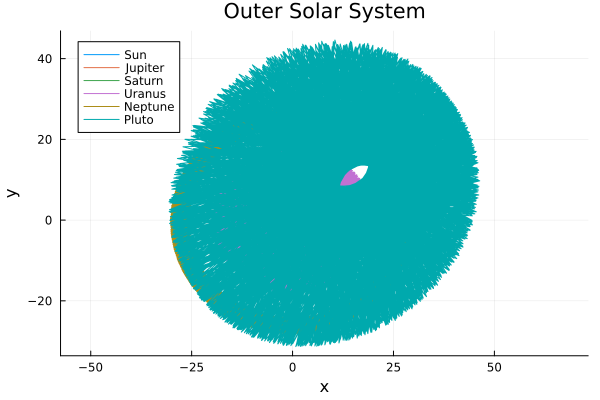

In [9]:
pl = plot(title="Outer Solar System", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:6
    x  = [u[1,j,1] for u in sol0.u]
    y  = [u[2,j,1] for u in sol0.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 
display(pl)

### IRKGL

In [10]:
m=100
dt=500.
alg=IRKGL_Seq(s=8, initial_interp=1, m=m,myoutputs=true)
alg2=IRKGL_simd(s=8, initial_interp=1, m=m, myoutputs=true)

sol1,iters1,steps1=solve(prob,alg,dt=dt, adaptive=false);
sol2,iters2,steps2=solve(prob,alg2,dt=dt, adaptive=false);

In [11]:
solve(prob,alg,dt=dt, save_everystep=false, adaptive=false);
cpu_IRKGLseq=0.
for i in 1:nruns
    cpu_IRKGLseq+=@elapsed solve(prob,alg,dt=dt, save_everystep=false, adaptive=false);
end
cpu_IRKGLseq=cpu_IRKGLseq/nruns

solve(prob,alg2,dt=dt,save_everystep=false, adaptive=false);
cpu_IRKGLsimd=0.
for i in 1:nruns
    cpu_IRKGLsimd+=@elapsed solve(prob,alg2,dt=dt, save_everystep=false, adaptive=false);
end
cpu_IRKGLsimd=cpu_IRKGLsimd/nruns;

### Sofronio

In [12]:
m=200
dt3=250.0
method = SofSpa10

m=400
dt3=250.0/2
method = KahanLi8

saveat=m*dt3
sol3=solve(prob2nd, method(), dt=dt3, saveat=saveat, adaptive=false);
T=typeof(u0)
solu3=Array{T}(undef,length(sol3.u));
for k in 1:length(sol3.u)
    solu3[k]=zero(u0)
    solu3[k][:,:,1].=sol3.u[k].x[2]
    solu3[k][:,:,2].=sol3.u[k].x[1]
end

In [13]:
solve(prob2nd, method(), dt=dt3, save_everystep=false, adaptive=false);
cpu_SofSpa10=0.
for i in 1:nruns
    cpu_SofSpa10+=@elapsed solve(prob2nd, method(), dt=dt3, save_everystep=false, adaptive=false)
end
cpu_SofSpa10=cpu_SofSpa10/nruns;

### DPRKN12

In [14]:
m=250
dt4=200.
saveat=m*dt4
sol4=solve(prob2nd, DPRKN12(), dt=dt4, saveat=saveat,adaptive=false);
T=typeof(u0)
solu4=Array{T}(undef,length(sol4.u));
for k in 1:length(sol4.u)
    solu4[k]=zero(u0)
    solu4[k][:,:,1].=sol4.u[k].x[2]
    solu4[k][:,:,2].=sol4.u[k].x[1]
end

In [15]:
solve(prob2nd, DPRKN12(), dt=dt4, save_everystep=false, adaptive=false);
cpu_DPRKN12=0.
for i in 1:nruns
    cpu_DPRKN12+=@elapsed solve(prob2nd, DPRKN12(), dt=dt4, save_everystep=false, adaptive=false)
end
cpu_DPRKN12=cpu_DPRKN12/nruns;

### Some checks

In [16]:
sols=[sol0, sol1, sol2, sol3, sol4]
for sol in sols
    println("length=",length(sol.t))
end

length=2001
length=2001
length=2001
length=2001
length=2001


In [17]:
k=20
for sol in sols[1:3]
    println("norm=", norm(sol0.u[1]-sol.u[1]), ", sol.t[k]=",sol.t[k], ", sol.t[end]=", sol.t[end])
end

norm=0.0, sol.t[k]=950000.0, sol.t[end]=1.0e8
norm=0.0, sol.t[k]=950000.0, sol.t[end]=1.0e8
norm=0.0, sol.t[k]=950000.0, sol.t[end]=1.0e8


<a href="#top">Back to the top</a>

## Errors in energy

In [23]:
println("CPU IRKGL_seq=$cpu_IRKGLseq, CPU IRKGL_simd=$cpu_IRKGLsimd, CPU IRKGL_seq/CPU IRKGL_simd=$(cpu_IRKGLseq/cpu_IRKGLsimd) ")
println("CPU SofSpa10=$cpu_SofSpa10, CPU DPRKN12=$cpu_DPRKN12" )

CPU IRKGL_seq=10.418000112, CPU IRKGL_simd=1.922196723, CPU IRKGL_seq/CPU IRKGL_simd=5.419840741243423 
CPU SofSpa10=1.495953746, CPU DPRKN12=1.023501655


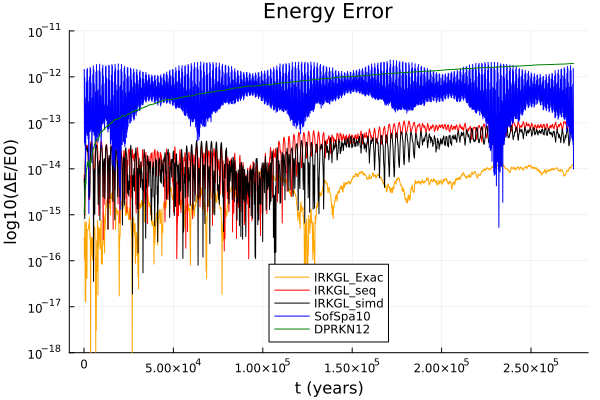

In [19]:
E0=NbodyEnergy(u0_B, Gm_B)
year=365.25
yrange=(1e-18,1e-11)
ΔE0 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol0.u)./E0.-1
ΔE1 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol1.u)./E0.-1
ΔE2 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), sol2.u)./E0.-1
ΔE3 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), solu3)./E0.-1
ΔE4 = map(x->NbodyEnergy(BigFloat.(x),Gm_B), solu4)./E0.-1
plot(title="Energy Error",xlabel="t (years)", ylabel="log10(ΔE/E0)", 
     yscale=:log10, ylims=yrange, legend=:bottom)
plot!(sol0.t./year,abs.(ΔE0),label="IRKGL_Exac", color="orange")
plot!(sol1.t./year,abs.(ΔE1),label="IRKGL_seq", color="red")
plot!(sol2.t/year,abs.(ΔE2),label="IRKGL_simd", color="black")
plot!(sol3.t/year,abs.(ΔE3),label="SofSpa10", color="blue")
plot!(sol4.t/year,abs.(ΔE4),label="DPRKN12", color="green")

In [20]:
Jupiter_period = 11.9*365
tF/Jupiter_period

23022.90779325429

<a href="#top">Back to the top</a>

## Errors in position

In [21]:
qe1=Array{Array{Float64,1}}(undef,N)
qe2=Array{Array{Float64,1}}(undef,N)
qe3=Array{Array{Float64,1}}(undef,N)
qe4=Array{Array{Float64,1}}(undef,N)
for i in 1:N
    qe1[i]=map((u0,u1)-> log10(norm(u0[:,i,1]-u1[:,i,1])), sol0.u[2:end],sol1.u[2:end])
    qe2[i]=map((u0,u1)-> log10(norm(u0[:,i,1]-u1[:,i,1])), sol0.u[2:end],sol2.u[2:end])
    qe3[i]=map((u0,u1)-> log10(norm(u0[:,i,1]-u1[:,i,1])), sol0.u[2:end],solu3[2:end])
    qe4[i]=map((u0,u1)-> log10(norm(u0[:,i,1]-u1[:,i,1])), sol0.u[2:end],solu4[2:end])
end

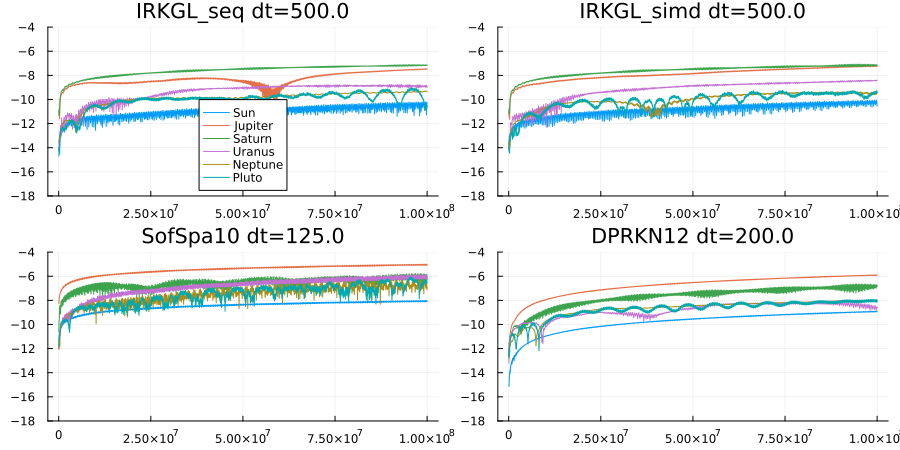

In [22]:
MinE=-18
MaxE=-4

pe1=plot(sol0.t[2:end], qe1,
         title="IRKGL_seq dt=$dt",
         ylims=(MinE,MaxE),
         label=bodylist,legend=:bottom)

pe2=plot(sol0.t[2:end], qe2,
     title="IRKGL_simd dt=$dt",
     ylims=(MinE,MaxE),
     legend=false)

pe3=plot(sol0.t[2:end], qe3,
         title="SofSpa10 dt=$dt3",
         ylims=(MinE,MaxE),
         legend=false)

pe4=plot(sol0.t[2:end], qe4,
         title="DPRKN12 dt=$dt4",
         ylims=(MinE,MaxE),
         legend=false)


plot(pe1, pe2, pe3, pe4, 
layout=(2,2), size=(900,450),plot_title="")